# Bias correction of numerical prediction model temperature forecast Data Set(Dynamics M20 projects - 17)

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso,Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

In [50]:
data=pd.read_csv('bias.csv',parse_dates=['Date'])
data
# This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea.
# This data consists of summer data from 2013 to 2017. 
# The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables.
# There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. 
# Hindcast validation was conducted for the period from 2015 to 2017.
# Target -> next_Tmax & next_Tmin


,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.000000,0.000000,0.000000,37.6046,126.991,212.3350,2.785000,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.000000,0.000000,0.000000,37.6046,127.032,44.7624,0.514100,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.000000,0.000000,0.000000,37.5776,127.058,33.3068,0.266100,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.000000,0.000000,0.000000,37.6450,127.022,45.7160,2.534800,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.000000,0.000000,0.000000,37.5507,127.135,35.0380,0.505500,5859.552246,31.2,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,2017-08-30,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,...,0.000000,0.000000,0.000000,37.5372,126.891,15.5876,0.155400,4443.313965,28.3,18.1
7748,24.0,2017-08-30,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,...,0.000000,0.000000,0.000000,37.5237,126.909,17.2956,0.222300,4438.373535,28.6,18.8
7749,25.0,2017-08-30,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,...,0.000000,0.000000,0.000000,37.5237,126.970,19.5844,0.271300,4451.345215,27.8,17.4
7750,NaN,NaT,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,...,0.000000,0.000000,0.000000,37.4562,126.826,12.3700,0.098475,4329.520508,17.4,11.3


In [51]:
df=pd.DataFrame(data=data)
df.info()
# Null values present in various columns 
# Datatype = 24 floattype & 1 datetime64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   station           7750 non-null   float64       
 1   Date              7750 non-null   datetime64[ns]
 2   Present_Tmax      7682 non-null   float64       
 3   Present_Tmin      7682 non-null   float64       
 4   LDAPS_RHmin       7677 non-null   float64       
 5   LDAPS_RHmax       7677 non-null   float64       
 6   LDAPS_Tmax_lapse  7677 non-null   float64       
 7   LDAPS_Tmin_lapse  7677 non-null   float64       
 8   LDAPS_WS          7677 non-null   float64       
 9   LDAPS_LH          7677 non-null   float64       
 10  LDAPS_CC1         7677 non-null   float64       
 11  LDAPS_CC2         7677 non-null   float64       
 12  LDAPS_CC3         7677 non-null   float64       
 13  LDAPS_CC4         7677 non-null   float64       
 14  LDAPS_PPT1        7677 n

# EDA 

In [52]:
df1=df.copy()
# Taking copy of the original datset

In [53]:
df1c=df1.dropna(axis=0)
df1c
# Lets drop all the rows carrying null values

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7745,21.0,2017-08-30,23.1,17.8,24.688997,78.261383,27.812697,18.303014,6.603253,9.614074,...,0.0,0.0,0.0,37.5507,127.040,26.2980,0.5721,4456.024414,27.6,17.7
7746,22.0,2017-08-30,22.5,17.4,30.094858,83.690018,26.704905,17.814038,5.768083,82.146707,...,0.0,0.0,0.0,37.5102,127.086,21.9668,0.1332,4441.803711,28.0,17.1
7747,23.0,2017-08-30,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,...,0.0,0.0,0.0,37.5372,126.891,15.5876,0.1554,4443.313965,28.3,18.1
7748,24.0,2017-08-30,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,...,0.0,0.0,0.0,37.5237,126.909,17.2956,0.2223,4438.373535,28.6,18.8


In [54]:
df1c.isnull().sum()
# No null values present now

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

# EDA on dates 

In [55]:
data_dates=pd.DataFrame()
data_dates['month']=data['Date'].dt.month_name()
data_dates['year']=data['Date'].dt.year
data_dates['day']=data['Date'].dt.day_name()
data_dates['Next_Tmax']=data['Next_Tmax']
data_dates

,month,year,day,Next_Tmax
0,June,2013.0,Sunday,29.1
1,June,2013.0,Sunday,30.5
2,June,2013.0,Sunday,31.1
3,June,2013.0,Sunday,31.7
4,June,2013.0,Sunday,31.2
...,...,...,...,...
7747,August,2017.0,Wednesday,28.3
7748,August,2017.0,Wednesday,28.6
7749,August,2017.0,Wednesday,27.8
7750,NaN,NaN,NaN,17.4


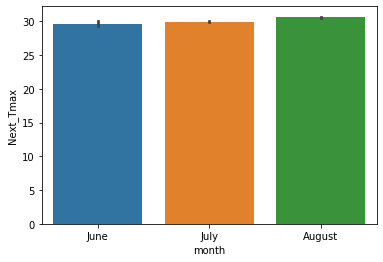

In [56]:
sns.barplot(x='month',y='Next_Tmax',data=data_dates)
plt.show()
# we can observe the temparature remains mote or less same over the three mmonths being anlysed here

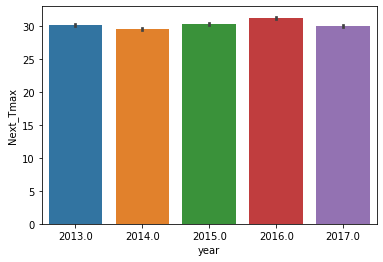

In [57]:
sns.barplot(x='year',y='Next_Tmax',data=data_dates)
plt.show()
# we can observe the temparature remains mote or less same over the 5 years being anlysed here.
# there is temarure drop obeserved in 2014 while 2015 & 2016 temparature went up. 
# the maxtimum temparure is observed around 30 degrees

In [58]:
df2c=df1c.drop('Date',axis=1)
# Now lets drop the 'date' column for further analysis purpose

# Univariate & Bivariate Analysis

In [59]:
df2c.columns

Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

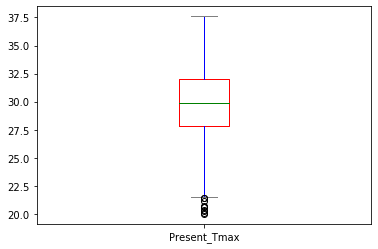

In [60]:
c={'boxes':'Red','whiskers':'Blue','medians':'Green','caps':'Grey'}
# fixing the color for boxplot
df2c['Present_Tmax'].plot.box(color=c)
# outliers present

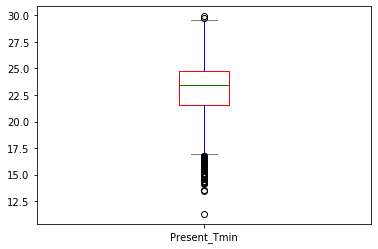

In [61]:
df2c['Present_Tmin'].plot.box(color=c)
# outliers present

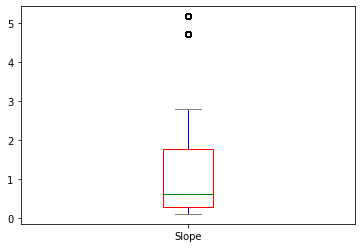

In [62]:
df2c['Slope'].plot.box(color=c) # Outliers present

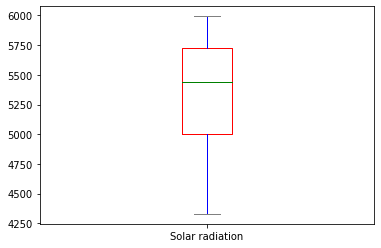

In [63]:
df2c['Solar radiation'].plot.box(color=c) # NO outliers present

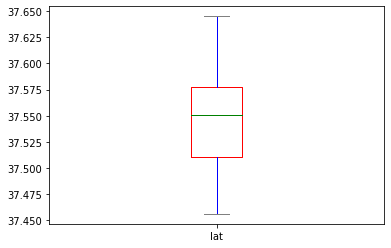

In [64]:
df2c['lat'].plot.box(color=c) # No outliers present

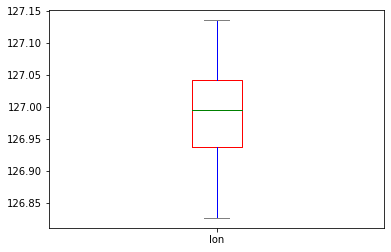

In [65]:
df2c['lon'].plot.box(color=c) # No Outliers present

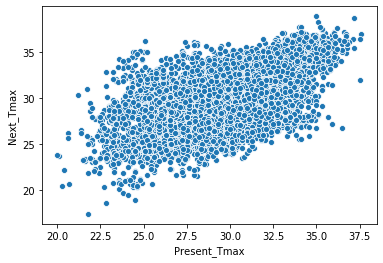

In [66]:
sns.scatterplot(data=df2c,x='Present_Tmax',y='Next_Tmax') # It shows these to are directly corelated 

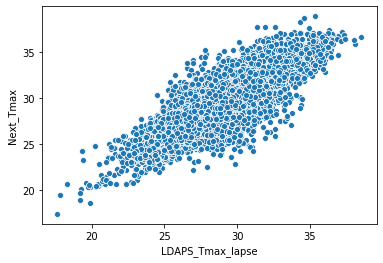

In [67]:
sns.scatterplot(data=df2c,x='LDAPS_Tmax_lapse',y='Next_Tmax') # itshows timelapse is directly corelated with temparuture

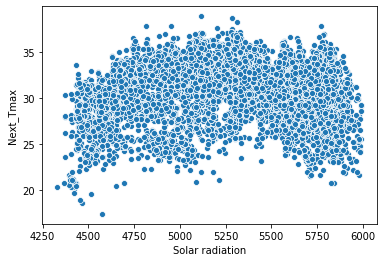

In [68]:
sns.scatterplot(data=df2c,x='Solar radiation',y='Next_Tmax') # Solar radiation is also positively relating with temparature

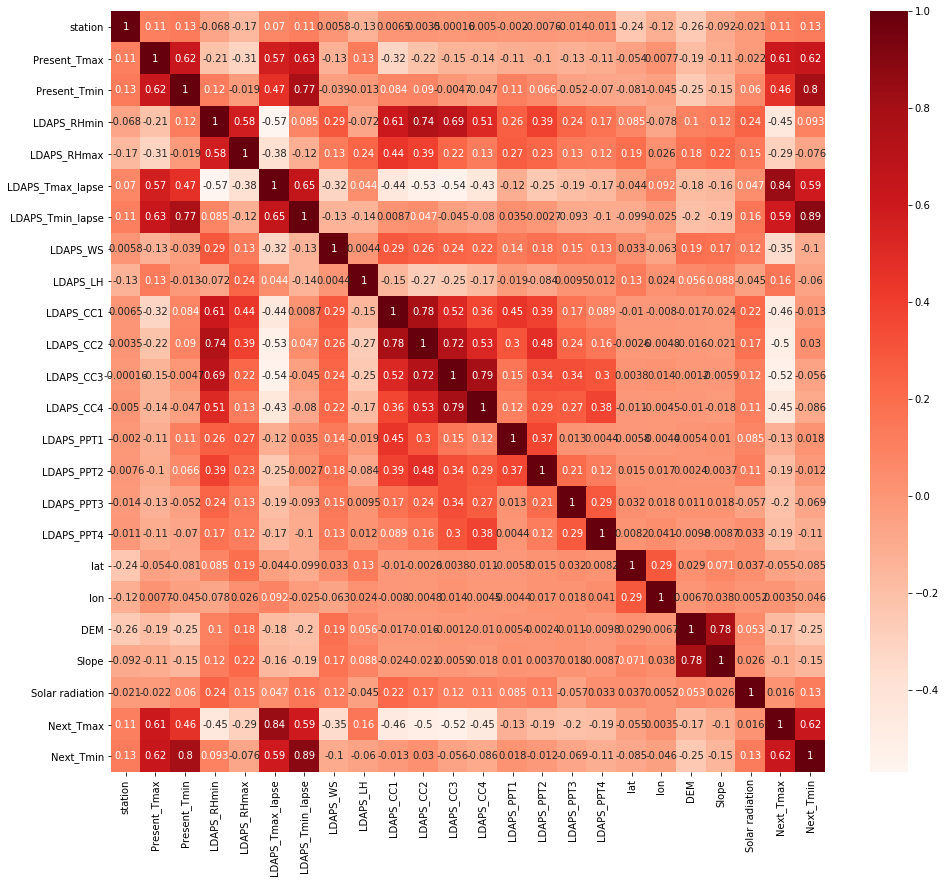

In [69]:
plt.figure(figsize=(16,14))
sns.heatmap(df2c.corr(),cmap='Reds',annot=True)
# Checking co reation of Temparure with other feature attributes

# Claening the Dataset

In [70]:
z=np.abs(zscore(df2c))
print(np.where(z>3))

(array([  25,   25,   26, ..., 7581, 7582, 7582], dtype=int64), array([ 7, 14, 14, ...,  2,  2,  6], dtype=int64))


In [71]:
dfn=df2c[(z<3).all(axis=1)]
dfn.shape

(6739, 24)

# Model Training and predicting the outputs

In [72]:
# There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data
# So we need to predict two data - Next_Tmax & Next_Tmin

In [73]:
x1=dfn.drop('Next_Tmax',axis=1) # feature columns for predicting Next_Tmax
y1=dfn['Next_Tmax'] # Target column

In [74]:
x2=dfn.drop('Next_Tmin',axis=1) # feature columns for predicting Next_Tmin
y2=dfn['Next_Tmin'] #Target column

In [75]:
sc=StandardScaler() # Scaling the data in order to avoid underfitting and overfitting of data
x1=sc.fit_transform(x1)
x2=sc.fit_transform(x2) 

In [76]:
xpca=PCA(n_components=10) # to avoid curse of dimensionality lets reduce the feature attributes to 10
x1=xpca.fit_transform(x1)
x2=xpca.fit_transform(x2)

# Task One - Predicting Next_Tmax 
# since the outout is continous, lets use Linear Regression to train the model

In [77]:
maxr=0
for i in range(41,100):
    x_train,x_test,y_train,y_test=train_test_split(x1,y1,random_state=i,test_size=0.3)
    lm=LinearRegression(normalize=True)
    lm.fit(x_train,y_train)
    pred=lm.predict(x_test)
    score=lm.score(x_train,y_train)
    print('Model score correspondng to random state',i,'is:',score)
    if score>maxr:
        maxr=score
        finalr=i
print()
print('maximum score corresponding to random state',finalr,'is',maxr)

Model score correspondng to random state 41 is: 0.7265896102800904
Model score correspondng to random state 42 is: 0.7326481225686983
Model score correspondng to random state 43 is: 0.7153665793438768
Model score correspondng to random state 44 is: 0.7219727954120445
Model score correspondng to random state 45 is: 0.7299009729177091
Model score correspondng to random state 46 is: 0.7214172643836999
Model score correspondng to random state 47 is: 0.7218719675935503
Model score correspondng to random state 48 is: 0.7289133722585309
Model score correspondng to random state 49 is: 0.7220095039349314
Model score correspondng to random state 50 is: 0.7379173914028208
Model score correspondng to random state 51 is: 0.7304517888677249
Model score correspondng to random state 52 is: 0.723199524171275
Model score correspondng to random state 53 is: 0.7255218349088557
Model score correspondng to random state 54 is: 0.7217430424801818
Model score correspondng to random state 55 is: 0.7202005422635

In [78]:
ls=Lasso()
alphavalue={'alpha':[0.0001,.001,.01,.1,1]}
grid=GridSearchCV(ls,param_grid=alphavalue)
grid.fit(x_train,y_train)
print(grid)
print(grid.best_score_)
print(grid.best_params_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.7229060884197616
{'alpha': 0.01}


In [79]:
ls=Lasso(alpha=0.01)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)

0.725045423426908

In [80]:
el=ElasticNet()
alphavalue={'alpha':[0.0001,.001,.01,.1,1]}
grid=GridSearchCV(el,param_grid=alphavalue)
grid.fit(x_train,y_train)
print(grid)
print(grid.best_score_)
print(grid.best_params_)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.7228433161647343
{'alpha': 0.01}


In [81]:
el=ElasticNet(alpha=0.01)
el.fit(x_train,y_train)
el.score(x_train,y_train)

0.7251051241641326

In [82]:
svr=SVR(kernel='linear')
svr.fit(x_train,y_train)
scoresvr=svr.score(x_train,y_train)
predsvr=svr.predict(x_test)
print(scoresvr)

0.7227781193334242


In [83]:
rf=RandomForestRegressor(n_estimators=400,random_state=60)

In [84]:
rf.fit(x_train,y_train)
pre_TMax=rf.predict(x_test)
print(rf.score(x_train,y_train))
print(pre_TMax)

0.969249263831055
[28.797   29.652   27.044   ... 28.9305  25.916   32.69775]


In [85]:
joblib.dump(rf,'rf_Tmax.obj')

['rf_Tmax.obj']

# Task Two- Predicting Next_Tmin 
# since the outout is continous, lets use Linear Regression to train the model

In [86]:
maxr=0
for i in range(41,100):
    x_train,x_test,y_train,y_test=train_test_split(x2,y2,random_state=i,test_size=0.3)
    lm=LinearRegression(normalize=True)
    lm.fit(x_train,y_train)
    pred=lm.predict(x_test)
    score=lm.score(x_train,y_train)
    print('accuracy score correspondng to random state',i,'is:',score)
    if score>maxr:
        maxr=score
        finalr=i
print()
print('maximum score corresponding to random state',finalr,'is',maxr)

accuracy score correspondng to random state 41 is: 0.7904692155764871
accuracy score correspondng to random state 42 is: 0.794446122388907
accuracy score correspondng to random state 43 is: 0.7846382760329016
accuracy score correspondng to random state 44 is: 0.7893889164446947
accuracy score correspondng to random state 45 is: 0.7949977916795379
accuracy score correspondng to random state 46 is: 0.7905681915670583
accuracy score correspondng to random state 47 is: 0.7953114159393386
accuracy score correspondng to random state 48 is: 0.7876715101898029
accuracy score correspondng to random state 49 is: 0.7865182808627682
accuracy score correspondng to random state 50 is: 0.7965424932784321
accuracy score correspondng to random state 51 is: 0.7911221023129222
accuracy score correspondng to random state 52 is: 0.7897670826873846
accuracy score correspondng to random state 53 is: 0.7883907480487822
accuracy score correspondng to random state 54 is: 0.7948222894183294
accuracy score corres

In [87]:
ls=Lasso()
alphavalue={'alpha':[0.0001,.001,.01,.1,1]}
grid=GridSearchCV(ls,param_grid=alphavalue)
grid.fit(x_train,y_train)
print(grid)
print(grid.best_score_)
print(grid.best_params_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.7849148288090786
{'alpha': 0.0001}


In [95]:
ls=Lasso(alpha=0.0001)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)

0.787162502830492

In [89]:
el=ElasticNet()
alphavalue={'alpha':[0.0001,.001,.01,.1,1]}
grid=GridSearchCV(el,param_grid=alphavalue)
grid.fit(x_train,y_train)
print(grid)
print(grid.best_score_)
print(grid.best_params_)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.784914942541684
{'alpha': 0.0001}


In [90]:
el=ElasticNet(alpha=0.0001)
el.fit(x_train,y_train)
el.score(x_train,y_train)

0.7871625118276755

In [91]:
svr=SVR(kernel='linear')
svr.fit(x_train,y_train)
scoresvr=svr.score(x_train,y_train)
predsvr=svr.predict(x_test)
print(scoresvr)

0.7833364960109803


In [92]:
rf=RandomForestRegressor(n_estimators=400,random_state=60)

In [93]:
rf.fit(x_train,y_train)
pre_TMin=rf.predict(x_test)
print(rf.score(x_train,y_train))
print(pre_TMin)

0.9788509801399764
[23.80975 23.67375 22.34925 ... 22.67525 16.879   26.3105 ]


In [94]:
joblib.dump(rf,'rf_Tmin.obj')

['rf_Tmin.obj']